# Language transformation using transliteration and machine translation models

In this project, we use transliteration to convert brand names from Hebrew to Latin letters and machine translation to translate product descriptions from Hebrew to English. By doing so, we gain access to a wide range  of well-developed, pre-trained language models available in English. This expansion enables us to analyze and compare products and brands on a global scale, empowering us with comprehensive insights.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from nltk.tokenize import word_tokenize

from transformers import pipeline
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from transformers import MarianMTModel, MarianTokenizer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
readRDS = robjects.r['readRDS']

In [2]:
categories = ["rice", "pasta","legumes and cereals","biscuits", "waffles", "chocolates", "black coffee", "toilet paper", "yogurt","cheese","canned food","wine","beer","water","non alcoholic carbonated beverages","non alcoholic non carbonated beverages","toothpaste","bread", "flour and semolina","gums and candies","honey and date honey", "jam and confiture", "ketchup, mayonnaise and mustard", "pastrami, sausage and kabanos", "pickled or smoked fish","deodorant","shower gel","shampoo"]
store= 1571

df = []
for category in categories:
    try:
        df_store = readRDS('D:/retail data/rds data/data by store/'+category+'/'+str(store)+'.rds')
        df_store = pandas2ri.rpy2py_dataframe(df_store)

        df_store['OverallCategory'] = category
        df_store = df_store[['Category','OverallCategory']]
        df_store = df_store.drop_duplicates()

        df.append(df_store)
    except:
        df_store = None
df = pd.concat(df)

In [3]:
# Import the product description data
data = pd.read_excel('C:/data/product_list.xlsx')
data = data[['Barcode','ProductDescription','Category','Manufacturer']]
data = pd.merge(data, df, how='inner',on="Category")

# Tokenization
data['Manufacturer'] = data['Manufacturer'].astype(str)
data['Manufacturer_token'] = data['Manufacturer'].apply(lambda tok: word_tokenize(tok.lower()))

data = data[:600]
data

,Barcode,ProductDescription,Category,Manufacturer,OverallCategory,Manufacturer_token
0,7290002333500,עדשים אדומות אורגני הרדוף 500 גרם,אורגני - אורז דגנים וקטניות,הרדוף,rice,[הרדוף]
1,7290002333098,גרגירי חומוס אורגני הרדוף 500 גרם,אורגני - אורז דגנים וקטניות,הרדוף,rice,[הרדוף]
2,7290011474478,זרעי צ'יה אורגניים תבואות 300 גרם,אורגני - אורז דגנים וקטניות,תבואות,rice,[תבואות]
3,7290011473211,עדשים אדומות אורגני תבואות 500 גרם,אורגני - אורז דגנים וקטניות,תבואות,rice,[תבואות]
4,7290011473181,עדשים שחורות אורגניים תבואות 500 גרם,אורגני - אורז דגנים וקטניות,תבואות,rice,[תבואות]
...,...,...,...,...,...,...
595,7290016381726,אורז פרא כרם 500 גרם,אורז,כרם,rice,[כרם]
596,7290016381726,אורז פרא כרם 500 גרם,אורז,כרם,rice,[כרם]
597,7290011473730,אורז פרא מעורב תבואות 1 קילו,אורז,תבואות,rice,[תבואות]
598,7290011473730,אורז פרא מעורב תבואות 1 קילו,אורז,תבואות,rice,[תבואות]


### EDA

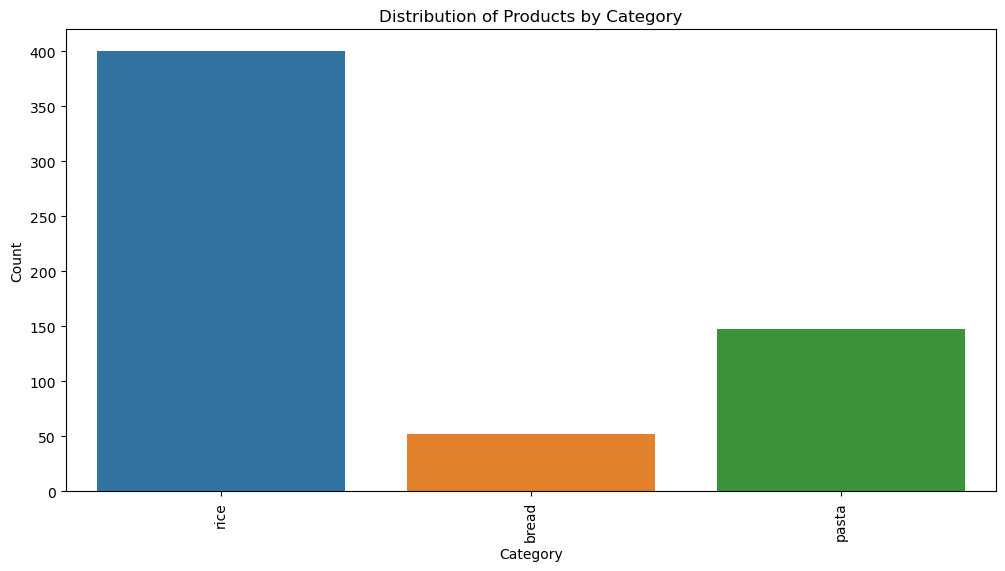

In [4]:
# Plot for category distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=data['OverallCategory'])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Products by Category')
plt.xticks(rotation=90)
plt.show()

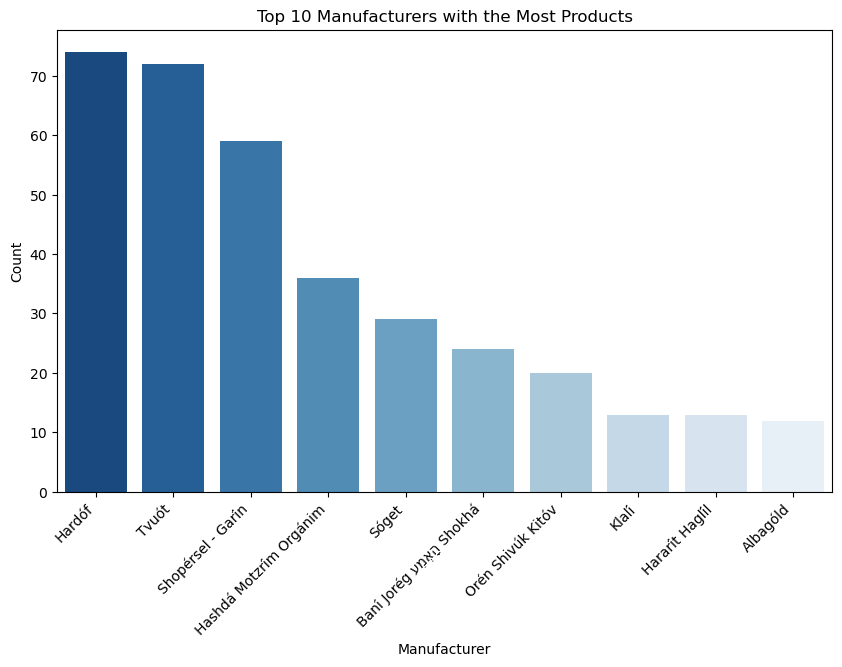

In [5]:
# Transliterat the manufacturer names
pipe = pipeline("text2text-generation", model="malper/taatiknet")

def taatiknet_transliteration(word_list):
    text = []
    for word in word_list:
        if word=='-':
            text.append(word)
        else:
            transliteration = pipe(word, num_beams=10, num_return_sequences=10, max_length=100)
            transliteration = transliteration[0]['generated_text'].capitalize()
            text.append(transliteration)
    return text

data['Manufacturer_Transliteration'] = data.apply(lambda row: taatiknet_transliteration(row['Manufacturer_token']), axis=1)
data['Manufacturer_Transliteration'] = data['Manufacturer_Transliteration'].apply(lambda x: ' '.join(x))

# Plot the most common manufacturers
plt.figure(figsize=(10, 6))
top_manufacturers = data['Manufacturer_Transliteration'].value_counts()[:10]
sns.barplot(x=top_manufacturers.index, y=top_manufacturers.values, palette='Blues_r')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.title('Top 10 Manufacturers with the Most Products')
plt.show()

### Transliteration

#### TaatikNet

TaatikNet is a ByT5-based model (which means that it does not use tokens) that can convert between Hebrew text and Latin transliteration and it is based on the Transformer architecture. The training dataset for the model consists around 15,000 pairs of Hebrew text and Latin transliteration.

In [6]:
pipe = pipeline("text2text-generation", model="malper/taatiknet")

In [7]:
def taatiknet_transliteration(word_list, text):
    
    for word in word_list:
        if word in text:
            transliteration = pipe(word, num_beams=10, num_return_sequences=10, max_length=100)
            transliteration = transliteration[0]['generated_text'].capitalize()
            
            text = text.replace(word, transliteration)
    return text

data['ProductDescription_Transliteration'] = data.apply(lambda row: taatiknet_transliteration(row['Manufacturer_token'], row['ProductDescription']), axis=1)
data

,Barcode,ProductDescription,Category,Manufacturer,OverallCategory,Manufacturer_token,Manufacturer_Transliteration,ProductDescription_Transliteration
0,7290002333500,עדשים אדומות אורגני הרדוף 500 גרם,אורגני - אורז דגנים וקטניות,הרדוף,rice,[הרדוף],Hardóf,עדשים אדומות אורגני Hardóf 500 גרם
1,7290002333098,גרגירי חומוס אורגני הרדוף 500 גרם,אורגני - אורז דגנים וקטניות,הרדוף,rice,[הרדוף],Hardóf,גרגירי חומוס אורגני Hardóf 500 גרם
2,7290011474478,זרעי צ'יה אורגניים תבואות 300 גרם,אורגני - אורז דגנים וקטניות,תבואות,rice,[תבואות],Tvuót,זרעי צ'יה אורגניים Tvuót 300 גרם
3,7290011473211,עדשים אדומות אורגני תבואות 500 גרם,אורגני - אורז דגנים וקטניות,תבואות,rice,[תבואות],Tvuót,עדשים אדומות אורגני Tvuót 500 גרם
4,7290011473181,עדשים שחורות אורגניים תבואות 500 גרם,אורגני - אורז דגנים וקטניות,תבואות,rice,[תבואות],Tvuót,עדשים שחורות אורגניים Tvuót 500 גרם
...,...,...,...,...,...,...,...,...
595,7290016381726,אורז פרא כרם 500 גרם,אורז,כרם,rice,[כרם],Karám,אורז פרא Karám 500 גרם
596,7290016381726,אורז פרא כרם 500 גרם,אורז,כרם,rice,[כרם],Karám,אורז פרא Karám 500 גרם
597,7290011473730,אורז פרא מעורב תבואות 1 קילו,אורז,תבואות,rice,[תבואות],Tvuót,אורז פרא מעורב Tvuót 1 קילו
598,7290011473730,אורז פרא מעורב תבואות 1 קילו,אורז,תבואות,rice,[תבואות],Tvuót,אורז פרא מעורב Tvuót 1 קילו


### Translation

#### MBart

MBart is a transformer-based model that was developed by Facebook AI. It is built on top of the BART model and has been pre-trained on a dataset of 1.56TB of parallel text, which includes text from 26 different languages. MBart uses a shared multilingual vocabulary and can translate between different language pairs without needing language-specific models.

In [8]:
# Load the pre-trained MBART model and tokenizer
model_name = "facebook/mbart-large-50-many-to-one-mmt"
model = MBartForConditionalGeneration.from_pretrained(model_name)
tokenizer = MBart50TokenizerFast.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
def mbart_translation(input_text):
    # Encode the input text
    encoded_input = tokenizer.encode(input_text, return_tensors="pt").to(device)

    # Generate translation
    generated_tokens = model.generate(input_ids=encoded_input, forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"], max_length=100,)
    decoded_translation = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
    
    return decoded_translation

data['ProductDescription_MBart_Translation'] = data.apply(lambda row: mbart_translation(row['ProductDescription_Transliteration']), axis=1)

#### Marian MT Model

Marian is a neural machine translation model that has been pre-trained on a massive dataset of parallel text that focuses on efficiency and simplicity. Marian MT has been pre-trained on a dataset of parallel text covering 100 different languages. Marian MT supports both single-language pair models and multilingual models, allowing translation between multiple languages using a single model.

In [10]:
model_name = "tiedeman/opus-mt-he-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

C:\Users\israe\anaconda3\lib\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [11]:
def marian_translation(input_text):
    # Encode the input text
    input_tokens = tokenizer.encode(input_text, return_tensors="pt", truncation=True)

    # Generate translation
    translated_tokens = model.generate(input_tokens)
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    
    return translated_text

data['ProductDescription_Marian_Translation'] = data.apply(lambda row: marian_translation(row['ProductDescription_Transliteration']), axis=1)

C:\Users\israe\anaconda3\lib\site-packages\transformers\generation\utils.py:1313: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


#### NLLB-200

NLLB-200 (No Language Left Behind) is a machine translation that can translate between 200 different languages. It achieved state-of-the-art results for a wide range of languages, including low-resource languages.

In [12]:
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", src_lang="heb_Hebr")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

In [13]:
def nllb_translation(input_text):
    # Encode the input text
    inputs = tokenizer(input_text, return_tensors="pt")
    
    # Generate translation
    translated_tokens = model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id["eng_Latn"], max_length=30)
    translated_text = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]
    
    return translated_text

data['ProductDescription_NLLB_Translation'] = data.apply(lambda row: nllb_translation(row['ProductDescription_Transliteration']), axis=1)

##### Comparison

In [14]:
data[['ProductDescription','ProductDescription_MBart_Translation','ProductDescription_Marian_Translation','ProductDescription_NLLB_Translation']]

,ProductDescription,ProductDescription_MBart_Translation,ProductDescription_Marian_Translation,ProductDescription_NLLB_Translation
0,עדשים אדומות אורגני הרדוף 500 גרם,Organic Hardóf red lenses 500 grams,Red lentils organic Hardóf 500 grams,Hardóf organic red lenses 500 grams
1,גרגירי חומוס אורגני הרדוף 500 גרם,Hardóf Organic Acid Grains 500 grams,An organic chickpea. Hardóf 500 grams.,"The first is the hardwood, which is a hardwood..."
2,זרעי צ'יה אורגניים תבואות 300 גרם,Organic Chinese seeds Tvuót 300 grams,Tvuót organic chi seeds 300 grams,Organic tea seeds Tvuót 300 grams
3,עדשים אדומות אורגני תבואות 500 גרם,Organic red lenses Tvuót 500 grams,Red lentils organic Tvuót 500 grams,Organic red lenses Tvuót 500 grams
4,עדשים שחורות אורגניים תבואות 500 גרם,Organic black lenses Tvuót 500 grams,Tvuót 500 grams organic black lentils,Organic black lenses Tvuót 500 grams
...,...,...,...,...
595,אורז פרא כרם 500 גרם,Karám wild rice 500 grams,Wild rice Karám 500 grams,Wild rice Karám 500 grams
596,אורז פרא כרם 500 גרם,Karám wild rice 500 grams,Wild rice Karám 500 grams,Wild rice Karám 500 grams
597,אורז פרא מעורב תבואות 1 קילו,Wild rice mixed Tvuót 1 kg,Wild rice mixed Tvuót 1 kilo,Wild rice mixed Tvuót 1 kg
598,אורז פרא מעורב תבואות 1 קילו,Wild rice mixed Tvuót 1 kg,Wild rice mixed Tvuót 1 kilo,Wild rice mixed Tvuót 1 kg


In [27]:
# Evaluation of translations by creating side-by-side comparison table
sample_data = data.sample(n=10)

for index, row in sample_data.iterrows():
    original_desc = row['ProductDescription']
    mBart_translation = row['ProductDescription_MBart_Translation']
    marian_translation = row['ProductDescription_Marian_Translation']
    nllb_translation = row['ProductDescription_NLLB_Translation']
    
    print("Original: ", original_desc)
    print("MBart Translation: ", mBart_translation)
    print("Marian Translation: ", marian_translation)
    print("NLLB Translation: ", nllb_translation)
    print("\n---\n")

Original:  קינואה אורגנית גרין 340 גרם
MBart Translation:  Organic canola Garín 340 grams
Marian Translation:  Garín organic quinoa 340 grams
NLLB Translation:  Organic quinone garín 340 grams

---

Original:  אורז בסמטי טילדה 1 קילו
MBart Translation:  Rice Samaty Tildá 1 kg
Marian Translation:  Packing in the Skilldá smats 1 kilo
NLLB Translation:  Rice in the form of Tildá 1 kg

---

Original:  אורז לסושי טעמי אסיה 1 קילו
MBart Translation:  Rice for Sushi Ta'amí Asyá 1 kg
Marian Translation:  Rice for sushi ta'amí Asianá 1 kg
NLLB Translation:  Rice for sushi Ta'amí Asyá 1 kg

---

Original:  תערובת קטניות למרק תבואות 500 גרם
MBart Translation:  Tiny mixture for Tvuót soup 500 grams
Marian Translation:  Bean mix for 500 grams tvuót soup
NLLB Translation:  Mix small amounts of Tvuót sauce 500 grams

---

Original:  לחם מלא פרוס אורגני גרין 750 גרם
MBart Translation:  Bread full of organic prosciutto Garín 750 grams
Marian Translation:  A whole slice of organic bread Garín 750 grams


Based on the manual evaluation of the translations, it appears that the Marian MT model performs the best in the translation process. It produce better quality compared to MBart and NLLB-200.